# Agent-based model

This is a model of embryonic neocortex population, using an agent-based framework.
This means that we create cells, on we sample a Tc from the age-related distribution.
At the end of cell cycle, the fate decision for the daughters are.

The model starts at E48, where we have the first data.

Data will be of different types :

Tc:
- Population level estimation
- Cell level estimation

Differentiation:
- Cell level estimation

Number of progenitors:
- Ki67 ratio in GZ
- Ratio of Tbr2+ and Sox2+

Number of cells:
- Relative volume from Histo + MRI
- Density of cells

We will have to discuss quality of the data

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from numpy.random import choice
from scipy.interpolate import splev, splrep, interp1d
from gpn import GrowingPlanarNetwork

In [110]:
nop = lambda *a, **k: None

## Loading data

In [2]:
# Volume MRI + Histo
volumes = pd.read_csv('data/VolumeArea17.csv')

## Preprocessing data

In [3]:
# from PolynomRegression
Tc_ = lambda time: 277.36424309532794 - 0.023973977538587 * time - 0.761568634472077 * time**2 + \
    0.025594287611410 * time**3 - 0.000307496975562 * time**4 + 0.000001264230759 * time**5
print("Polynom Reg", Tc_(48), Tc_(65), Tc_(78))

Polynom Reg 41.8919627067869 64.8715873071742 55.96794765296363


In [4]:
# what we do is to average some ages
volumes = volumes.append(volumes.loc[volumes.Age.isin([70, 72])].mean(), ignore_index=True)
volumes = volumes.append(volumes.loc[volumes.Age.isin([78, 79])].mean(), ignore_index=True)
volumes = volumes.append(volumes.loc[volumes.Age.isin([84, 86])].mean(), ignore_index=True)
volumes = volumes.loc[~volumes.Age.isin([70, 72, 78, 79, 84, 86])]

In [5]:
col = volumes.loc[:, ["Ratio_Histo_VZ", "Ratio_MRI_VZ"]]
volumes['Ratio_VZ'] = col.mean(axis=1)
col = volumes.loc[:, ["Ratio_Histo_ISVZ", "Ratio_MRI_ISVZ"]]
volumes['Ratio_ISVZ'] = col.mean(axis=1) * volumes.loc[0, "Histo_ISVZ"] / volumes.loc[0, "Histo_VZ"]
col = volumes.loc[:, ["Ratio_Histo_OSVZ", "Ratio_MRI_OSVZ"]]
volumes['Ratio_OSVZ'] = col.mean(axis=1) * volumes.loc[0, "Histo_OSVZ"] / volumes.loc[0, "Histo_VZ"]

In [6]:
volumes.loc[:, ["AverageDensityVZ", "AverageDensityISVZ", "AverageDensityOSVZ"]] /= \
    volumes.loc[0, "AverageDensityVZ"]
volumes["total_cell_number"] = volumes["AverageDensityVZ"] * volumes["Ratio_VZ"] + \
                               volumes["AverageDensityISVZ"] * volumes["Ratio_ISVZ"] + \
                               volumes["AverageDensityOSVZ"] * volumes["Ratio_OSVZ"]
volumes.head()

,Age,Histo_VZ,Histo_ISVZ,Histo_OSVZ,Histo_SP,Histo_CP,MRI_VZ,MRI_ISVZ,MRI_OSVZ,MRI_SP,...,RelativeDensityVZ,RelativeDensityISVZ,RelativeDensityOSVZ,AverageDensityVZ,AverageDensityISVZ,AverageDensityOSVZ,Ratio_VZ,Ratio_ISVZ,Ratio_OSVZ,total_cell_number
0,49.0,0.264,0.118,0.012,NaN,0.056,0.527,0.236,0.024,NaN,...,1.000,1.00,1.000,1.000000,0.441331,0.044134,1.0000,0.446970,0.045455,1.199268
1,63.0,0.716,0.428,3.666,NaN,2.284,1.161,0.698,5.871,4.807,...,0.820,1.34,10.540,0.821235,0.592874,0.465094,2.4590,1.474330,12.733250,8.815673
8,94.0,0.910,0.767,6.152,NaN,15.344,NaN,NaN,NaN,NaN,...,0.230,0.28,2.800,0.234263,0.121405,0.123754,3.4520,2.909773,23.732864,4.098968
9,71.0,0.615,0.498,5.095,NaN,3.962,1.880,1.486,15.337,17.782,...,0.545,0.93,7.330,0.542118,0.409147,0.323570,2.9495,2.352625,24.617727,10.527115
10,78.5,0.374,0.342,4.686,NaN,5.366,1.030,0.957,12.835,17.322,...,0.480,0.88,5.495,0.477197,0.387065,0.242614,1.6895,1.556795,21.415750,6.604573


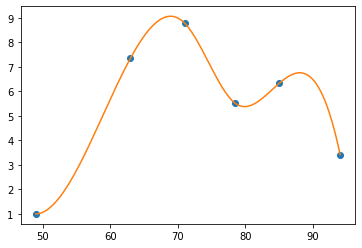

In [7]:
# complicated stuff to sort the list
sorted_number_cells = tuple(zip(*tuple(sorted(list(zip(volumes["Age"],
                                                       volumes["total_cell_number"] /
                                                       volumes.loc[0, "total_cell_number"])),
                                              key=lambda x: x[0]))))
spl = splrep(*sorted_number_cells)
x2 = np.linspace(49, 94, 200)
y2 = splev(x2, spl)
plt.plot(*sorted_number_cells, 'o', x2, y2)
plt.show()

In [8]:
def callback():
    plt.plot(*sorted_number_cells, 'o', x2, y2)

In [9]:
# Cell fate will be the first parameter to tune

In [20]:
# Definition of the var of the model
# We start with 100 cells for homogeneity
START_POPULATION_SQRT = 10
START_TIME = 49
END_TIME = 94
# We arbitrarily set variance of Tc at 12.5^2
# 95 % seems to be into 50, so sigma = 50 / 4 = 12.5
SIG_TC = 12.5

<Figure size 1440x1440 with 0 Axes>

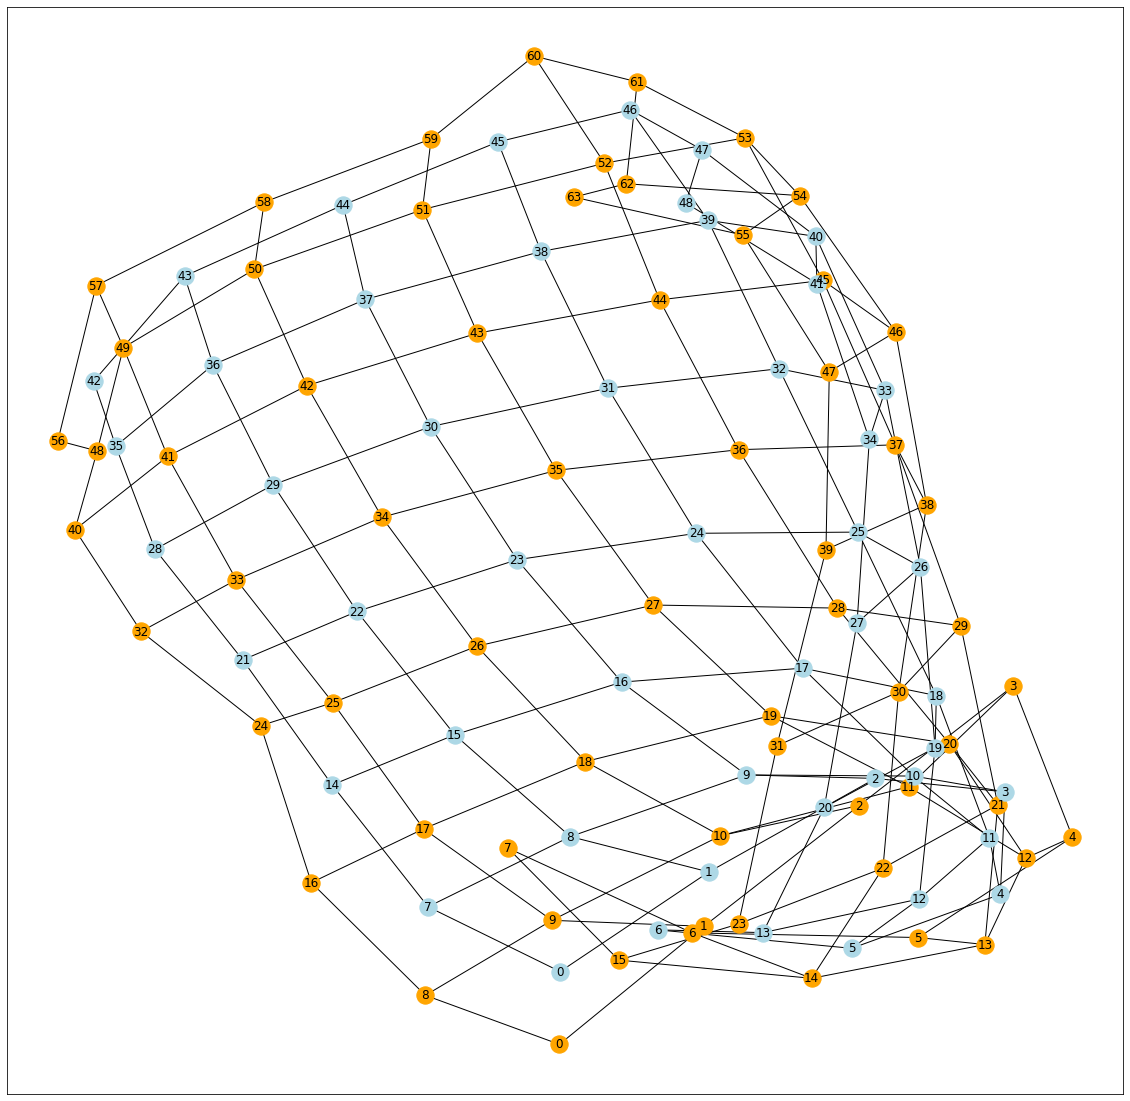

In [19]:
gpn = GrowingPlanarNetwork()
gpn.init_square(8)
plt.figure(figsize=(20, 20))
gpn.show_all(figsize=(20, 20))

In [27]:
bb = Brain()

In [28]:
len(bb.population)

100

In [108]:
"""
k_n = k_ref / (0.9 + p / 10)  # so as effective k stay the same even though p changes
k_p = 0.9 * k_n
"""
pass
# This is the formula to adapt k (1/Tc) according to progenitor

In [111]:
from enum import Enum

class CellTypeBasic(Enum):
    Cycling = 0
    PostMitotic = 1
    Dead = 2
    
class CellTypeClassic(Enum):
    RG = 0
    IP = 1
    PostMitotic = 2
    Dead = 3
    
class Action(Enum):
    NoOp = 0
    Divide = 1
    Die = 2
    DiffNeuron = 3
    DiffIP = 4
    Migrate = 5

In [34]:
class Submodels:
    """
    This class implements all parameters that are required, also under the callback form
    """
    def __init__(self, Tc_func, diff_func):
        self.Tc = Tc_func
        self.diff = diff_func

In [112]:
def tc_func_1(time_, type_):
    return max(np.random.normal(Tc_(time_), SIG_TC), 10) / 24. # because we are in Days

timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)

def diff_func_1(time_, type_):
    val = lin_diff(time_)
    return choice([CellTypeBasic.Cycling, CellTypeBasic.PostMitotic], 1, p=[val, 1-val])[0]

diff_func_1(49, None)

<CellTypeBasic.PostMitotic: 1>

In [106]:
submodel1 = Submodels(tc_func_1, diff_func_1)

In [135]:
def cell_fate(T):
    return 0.5 # return choice(["cycling", "postmitotic"], 1, p=[0.5, 0.5])

# Definition of the class
class Brain:
    
    ##################
    # INITIALISATION #
    ##################
    
    def __init__(self,
                 start_population=START_POPULATION_SQRT,
                 start_time=START_TIME,
                 end_time=END_TIME,
                 time_step=1,
                 sig_tc=SIG_TC,
                 submodel=None,
                ):
        self.start_population = start_population
        self.start_time = start_time
        self.end_time = end_time
        self.time_step = time_step
        self.sig_tc = SIG_TC
        self.submodel = submodel
        self.gpn = GrowingPlanarNetwork()
        self.initiate_population()
        self.reference_model_callback = lambda: None
        
    def set_reference_model(self, callback):
        self.reference_model_callback = callback
        
    def initiate_population(self):
        self.gpn.init_square(self.start_population)
        self.population = {i: Cell(self.start_time, start=True, brain=self, index=i, submodel=self.submodel)
                           for i in self.gpn.G.nodes}
        self.old_population = dict()
        
    ##################
    #### CLOCKING ####
    ##################

    def run(self):
        for T in np.arange(self.start_time, self.end_time, self.time_step):
            self._tick(T, self.time_step)

        return df_pop
    
    def _tick(self, absolute_time, relative_time):
        self._sanity_check()
        
        # take care of cells
        for C in self.population.values():
            neighbours = self.get_neighbours(C)
            action = C.tick(absolute_time, relative_time, neighbours)
            self.run_action(action, C, absolute_time)
                    
        # monitor
        stats = dict(progenitor_pop_size=len(self.population),
                     whole_pop_size=len(self.old_population) + len(self.population),
                     time=absolute_time,
                    )
        
        self.add_stat_time(absolute_time, stats)
    
    def _sanity_check(self):
        if len(self.population) > 1e5:
            raise RuntimeError("Model stops when population increases above 1E5")
            
    #################
    ###  ACTIONS  ###
    #################
    
    def run_action(self, action, cell, T):
        mapping = {
            Action.Divide: self.divide,
            Action.Die: self.remove_cell,
            Action.DiffNeuron: self.remove_cell,
            Action.DiffIP: nop,
            Action.NoOp: nop,
        }
        
        mapping[action](cell, T)
        
    def divide(self, cell, T):
        """
        Warning : the id of one daughter is the same as for the mother
        We will have to modify the gpn code to overcome that
        """
        new_cell = cell.generate_daughter_cell(T)
        new_index = self.gpn.duplicate_node(cell.index)
        new_cell.index = new_index
        self.population[new_index] = new_cell
        self.population[cell.index] = cell.generate_daughter_cell(T)
    
    def remove_cell(self, cell, T):
        self.gpn.remove_node(cell.index)
        self.old_population[cell.index] = cell
        self.population[cell.index] = None
            
    #################
    ###  HELPERS  ###
    #################
            
    def get_neighbours(self, cell):
        ngbs = self.gpn.ngb(cell.index)
        return [self.population[i] for i in ngbs]
    
    ##################
    ### STATISTICS ###
    ##################
    
    def init_stats(self):
        self.stats = pd.DataFrame({"cycling_size": [self.start_population],
                               "total_size": [self.start_population],
                               "time": [self.start_time]},
                               index=[self.start_time]
                             )
    
    def add_stat_time(self, abs_time, stats: dict):
        self.stats.append(pd.Series(stats, name=abs_time))
    
    def show_end_curve(self, df_pop):
        xspace = range(int(self.start_time), int(self.end_time) + 1)
        plt.figure(figsize=(18, 12))
        
        plt.subplot(2, 2, 1)
        plt.title("Number or progenitors")
        plt.plot(xspace, df_pop["cycling_size"] / 100)
        self.reference_model_callback() # plt.plot(*sorted_number_cells, 'o', x2, y2)

        plt.subplot(2, 2, 2)
        plt.title("Rate of differentation")
        y_diff = [self.cell_fate_func(x) for x in xspace]
        plt.plot(xspace, y_diff)
        
        plt.subplot(2, 2, 3)
        plt.title("Number or total cells")
        plt.plot(xspace, df_pop["total_size"] / 100)
        
        plt.subplot(2, 2, 4)
        plt.title("Time of cell cycle")
        y_Tc = [self.Tc_func(x) for x in xspace]
        plt.ylim(0, max(100, np.max(y_Tc)))
        plt.plot(xspace, y_Tc)
        plt.show()  
      
    
    
class Cell:
    def __init__(self, T, start=False, brain=None, index=None, submodel=None):
        # references
        self.brain = brain
        self.submodel = submodel
        
        # cell data
        self.appear_time = T
        self.division_time = np.Inf
        self.index = index
        
        if start:
            self._type = CellTypeBasic.Cycling
        else:
            self._type = self.submodel.diff(T, None)
        
        if self._type == CellTypeBasic.Cycling:
            self.cycle(T, start)
            
    def tick(self, abs_time, rel_time, neighbours=None):
        if self._type != CellTypeBasic.Cycling:
            return Action.DiffNeuron
        
        elif abs_time > self.division_time:
            return Action.Divide
        
        else:
            return Action.NoOp
            
    def cycle(self, T, start=False):
        self.Tc = self.submodel.Tc(T, None)
        if start:
            self.eff_Tc = np.random.uniform(0, self.Tc)
        else:
            self.eff_Tc = self.Tc
        self.division_time = T + self.eff_Tc
    
    def __gt__(self, C):
        return self.division_time > C.division_time
    
    def generate_daughter_cell(self, T):
        return Cell(T, start=False, brain=self.brain, submodel=submodel)

In [136]:
bb = Brain(time_step=0.5, submodel=submodel1)

In [137]:
bb.run()

AttributeError: 'Brain' object has no attribute 'stats'

In [ ]:
b = Brain()
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=lambda x: 50)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lambda x: lin_diff(x) * 1.1)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=lambda x: Tc_(x) * 0.9)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=lambda x: Tc_(49))
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.47, 0.45, 0.45])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=lambda x: 60)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.73, 0.63, 0.40, 0.80, 0.35])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=Tc_)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = np.array([49, 61, 72, 83, 95])
diff_values = np.array([0.75, 0.64, 0.38, 0.60, 0.30])
lin_diff = interp1d(timesteps, diff_values)
b = Brain(cell_fate_func=lin_diff, Tc_func=Tc_)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
a = 1.28
c = 1 / 80.
b = Brain(cell_fate_func=lambda x: a - Tc_(x) * c, Tc_func=Tc_)
b.set_reference_model(callback)
df_pop = b.run()
b.show_end_curve(df_pop)

In [ ]:
timesteps = [49, 61, 72, 83, 95]
diff_values = [0.73, 0.50, 0.47, 0.80, 0.45]
lin_diff = interp1d(timesteps, diff_values)
x_diff = np.linspace(49, 95, 100)
y_diff = lin_diff(x_diff)
plt.plot(timesteps, diff_values, 'o', x_diff, y_diff)
plt.show()

In [ ]:
timesteps = [49, 61, 72, 83, 95]
diff_values = [0.73, 0.63, 0.47, 0.45, 0.45]
spl_diff = splrep(timesteps, diff_values)
x_diff = np.linspace(49, 95, 100)
y_diff = splev(x_diff, spl_diff)
plt.plot(timesteps, diff_values, 'o', x_diff, y_diff)
plt.show()

In [ ]:
# Tuning cell_fate
def cell_fate_trial(T):
    val = splev(T, spl_diff)
    return val

def cell_fate_lin_f(func):
    def ret_func(T):
        val = func(T)
        return choice(["cycling", "postmitotic"], 1, p=[val, 1-val])
    return ret_func